In [ ]:
!pip install pytorch-lightning==1.5.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 55.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 59.5.0 which is incompatible.
cvxpy 1.3.2 requires setu

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader , random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 32
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1 , torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__(self , data_dir = "./data" , batch_size = BATCH_SIZE , num_workers = NUM_WORKERS):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    #Convert the image to tensor and normalize
    self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

  #Function to download the dataset from MNIST
  def prepare_data(self):
    MNIST(self.data_dir , train = True , download = True)
    MNIST(self.data_dir , train = False , download = True)

  def setup(self , stage = None):
    #Splitting the training dataset to train , validation
    if stage == "fit" or stage is None:
      mnist_full =  MNIST(self.data_dir , train = True , transform = self.transform)
      self.mnist_train , self.mnist_val = random_split(mnist_full , [55000 , 5000])

    if stage == "test" or stage is None:
      self.mnist_test = MNIST(self.data_dir , train = False , transform = self.transform)


#Dataloader ,retrieves images in sizes of batch_size ,can also set shuffle = True to shuffle data after all batches
  def train_dataloader(self):
    return DataLoader(self.mnist_train , batch_size = self.batch_size , num_workers = self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val , batch_size = self.batch_size , num_workers = self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.mnist_test , batch_size = self.batch_size , num_workers = self.num_workers)



In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    #CNN

    self.conv1 = nn.Conv2d(1 , 10 ,kernel_size = 5)
    self.conv2 = nn.Conv2d(10 , 20 , kernel_size = 5)

    self.conv2_drop = nn.Dropout2d()

    self.fc1 = nn.Linear(320 , 50)  #Fully connected layer ->linear
    self.fc2 = nn.Linear(50 ,1)

  #Relu + max_pool
  def forward(self , x):
    x = F.relu(F.max_pool2d(self.conv1(x) , 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)) , 2))

    #Flatten tensor to feed into the fully connvected layers
    x = x.view(-1 , 320)

    x = F.relu(self.fc1(x))
    x = F.dropout(x , training = self.training)
    x = self.fc2(x)
    #Converts into [0,1]
    return torch.sigmoid(x)



In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [ ]:
class GAN(pl.LightningModule):
  def __init__ (self , latent_dim = 100 , lr = 0.0002):
    super().__init__()
    self.save_hyperparameters()

    self.generator = Generator(latent_dim = self.hparams.latent_dim)

    self.discriminator = Discriminator()

    #Random Noise
    self.validation_z = torch.randn(6,self.hparams.latent_dim)

  def forward(self , z):
    return self.generator(z)

  def adversarial_loss(self , y_hat ,y):
    #yhat = predicted , y = real
    return F.binary_cross_entropy(y_hat , y)

  def training_step(self , batch,batch_idx,optimizer_idx):
    real_images , _ = batch

    #sample noise
    z = torch.randn(real_images.shape[0] , self.hparams.latent_dim)
    z = z.type_as(real_images)

    #Training generator  max log(D(G(z)))   z = random noise
    if optimizer_idx == 0:
      fake_images = self(z)
      y_hat = self.discriminator(fake_images)

      y = torch.ones(real_images.size(0) , 1)
      y = y.type_as(real_images)

      g_loss = self.adversarial_loss(y_hat , y)

      log_dict = {"g_loss":g_loss}
      return {"loss" : g_loss , "progress_bar" : log_dict , "log":log_dict}

    if optimizer_idx == 1:
      #Training discriminator max log(D(x)) + log(1- D(G(z)) )x => original images

      #As real
      y_hat_real = self.discriminator(real_images)

      y_real = torch.ones(real_images.size(0) , 1)
      y_real = y_real.type_as(real_images)

      real_loss = self.adversarial_loss(y_hat_real , y_real)

      #Label as fake

      y_hat_fake = self.discriminator(self(z).detach())

      y_fake = torch.zeros(real_images.size(0) , 1)
      y_fake = y_fake.type_as(real_images)

      fake_loss = self.adversarial_loss(y_hat_fake , y_fake)

      d_loss = (real_loss + fake_loss) / 2

      log_dict = {"d_loss" : d_loss}

      return {"loss": d_loss , "progress_bar":log_dict , "log":log_dict}




  def configure_optimizers(self):
    lr = self.hparams.lr
    #Optimizer used - adam
    opt_g = torch.optim.Adam(self.generator.parameters() , lr = lr)

    opt_d = torch.optim.Adam(self.discriminator.parameters() , lr = lr)

    return [opt_g , opt_d] , []

  def plot_imgs(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_images = self(z).cpu()

    print("epoch" , self.current_epoch)
    fig = plt.figure()

    for i in range(sample_images.size(0)):
      plt.subplot(2 ,3  , i+1)
      plt.tight_layout()
      plt.imshow(sample_images.detach()[i , 0 ,: ,:] , cmap="gray_r" , interpolation = "none")
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis("off")

    plt.show()

    print('')
  def on_epoch_end(self):
    self.plot_imgs()


In [ ]:
dm = MNISTDataModule()
model = GAN()

epoch 0


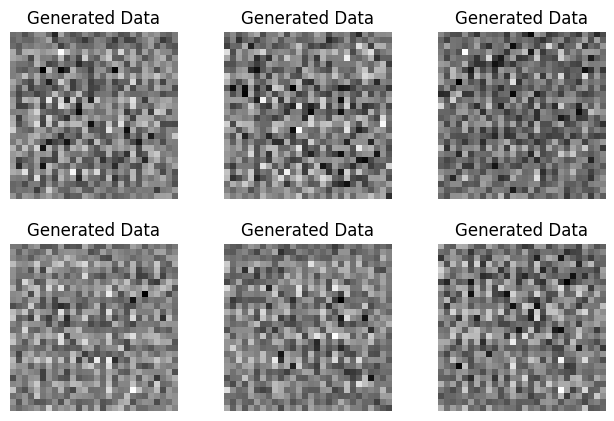

In [ ]:
model.plot_imgs()

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estim

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'progress_bar', 'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


epoch 0


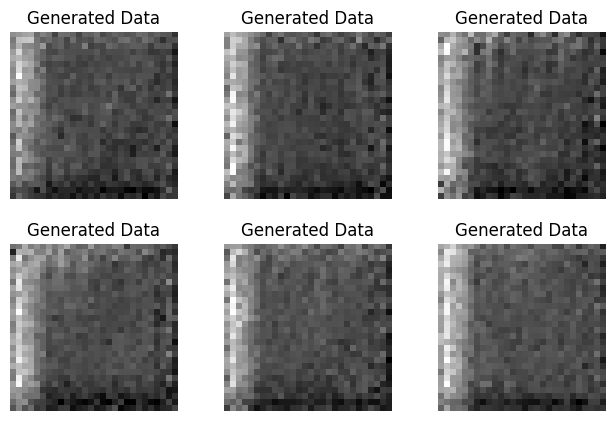


epoch 1


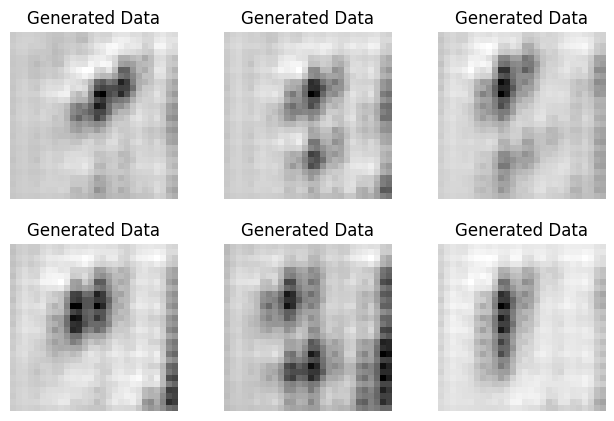


epoch 2


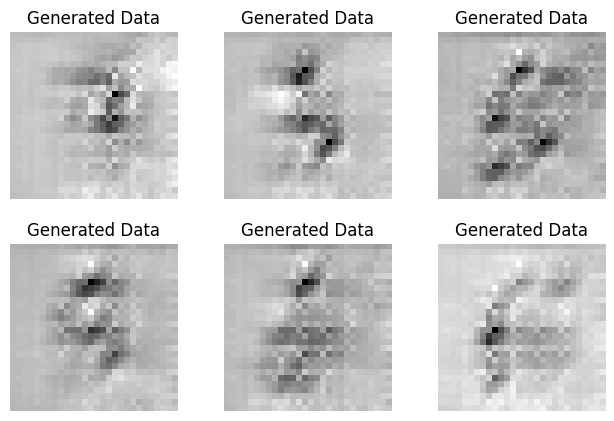


epoch 3


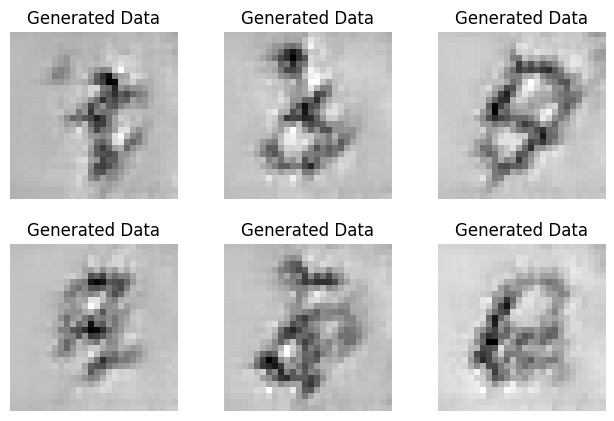


epoch 4


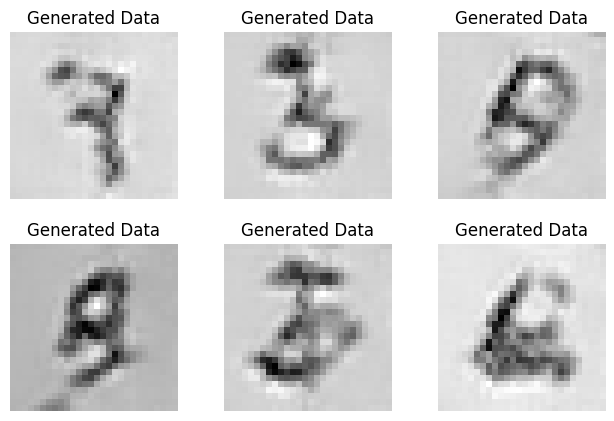


epoch 5


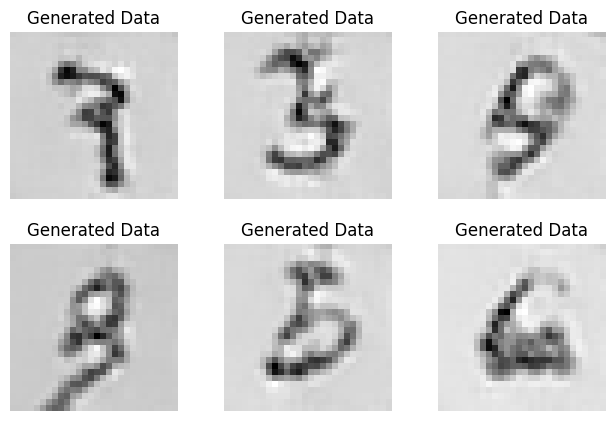


epoch 6


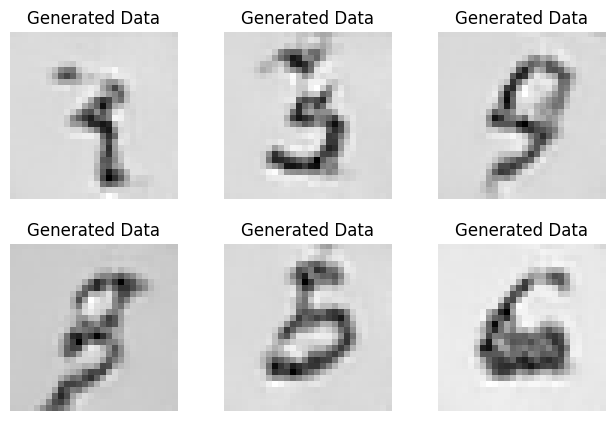


epoch 7


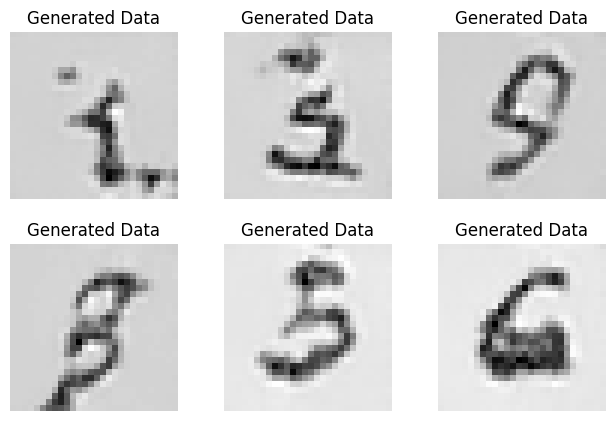


epoch 8


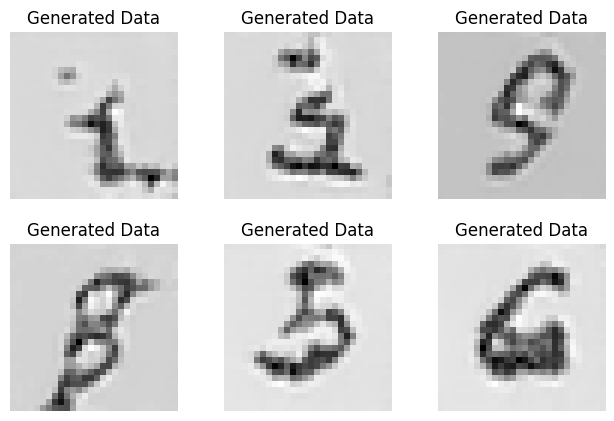


epoch 9


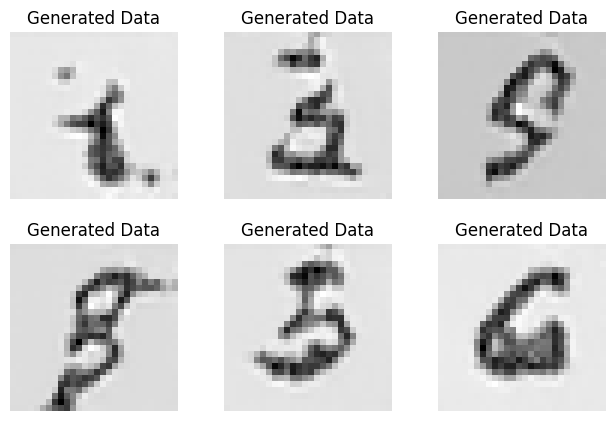


epoch 10


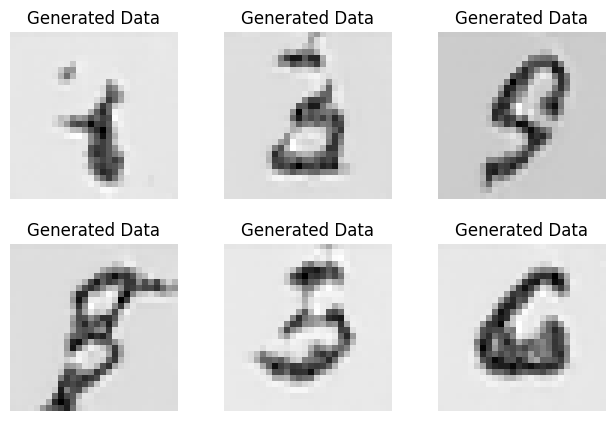


epoch 11


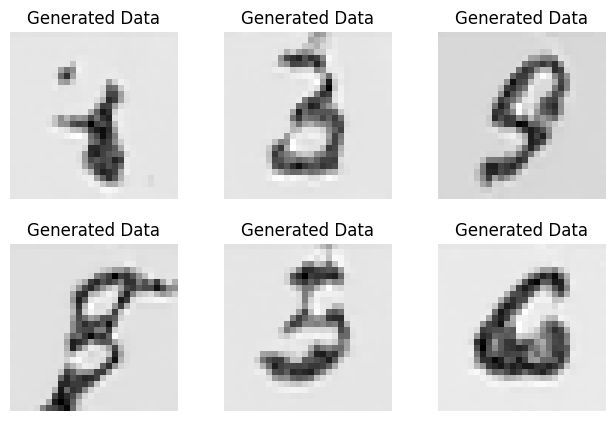


epoch 12


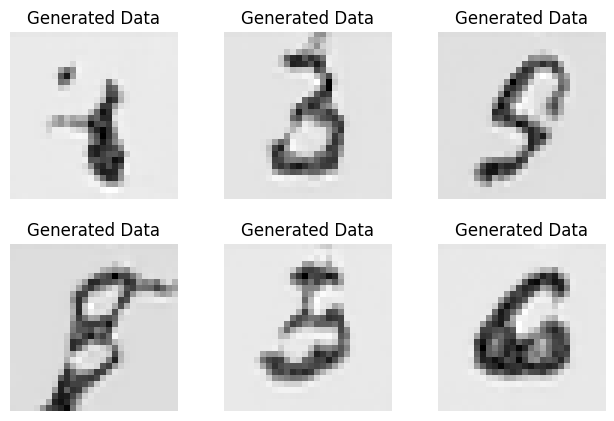


epoch 13


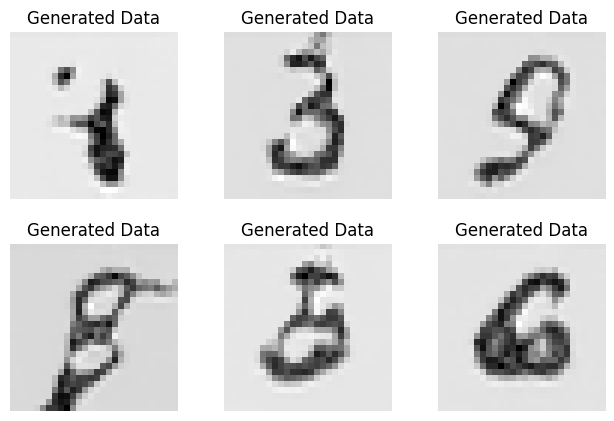


epoch 14


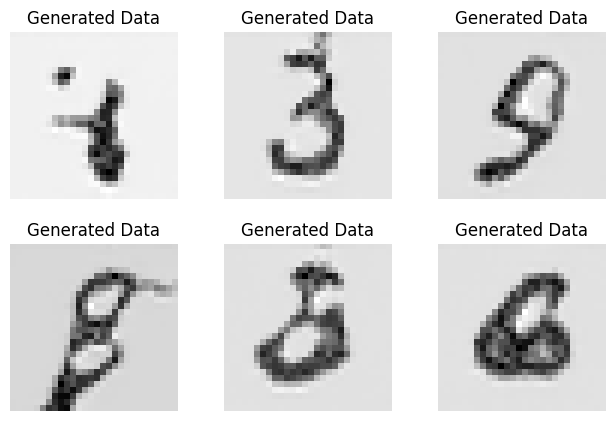


epoch 15


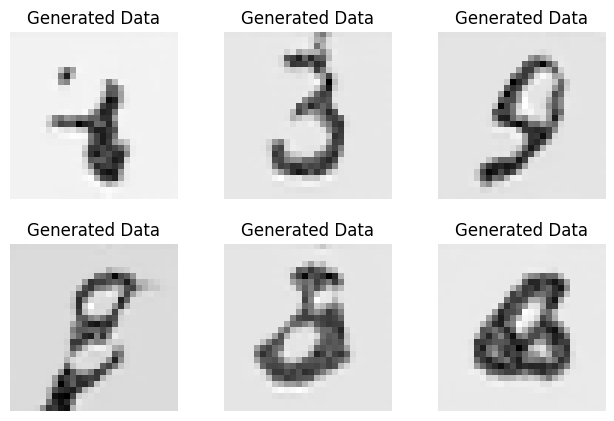


epoch 16


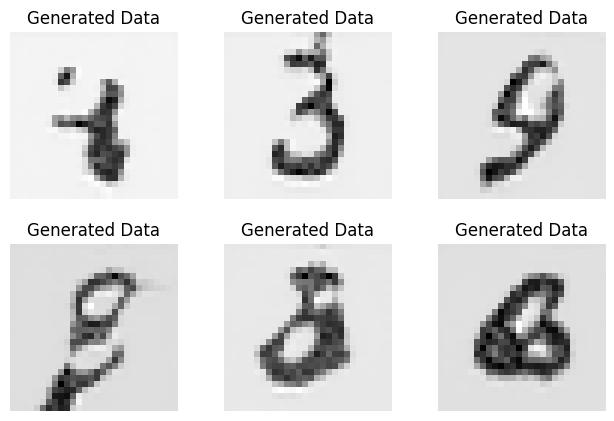


epoch 17


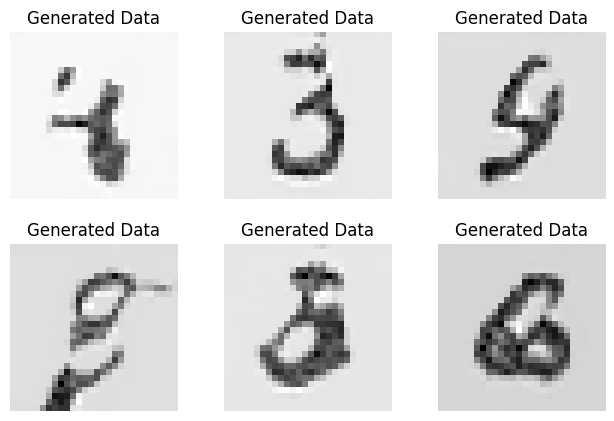


epoch 18


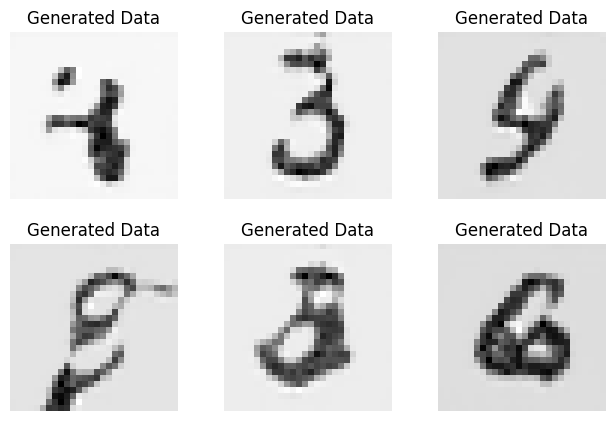


epoch 19


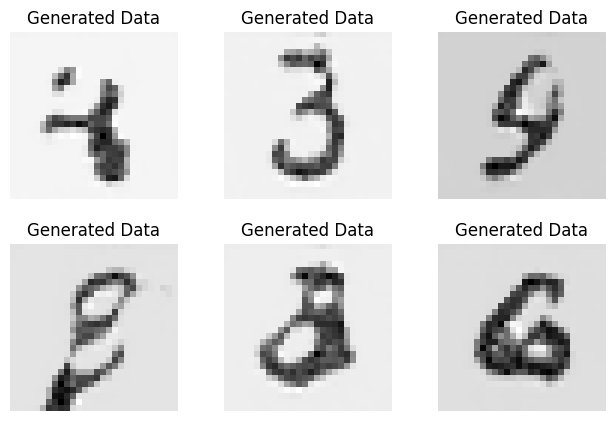


epoch 20


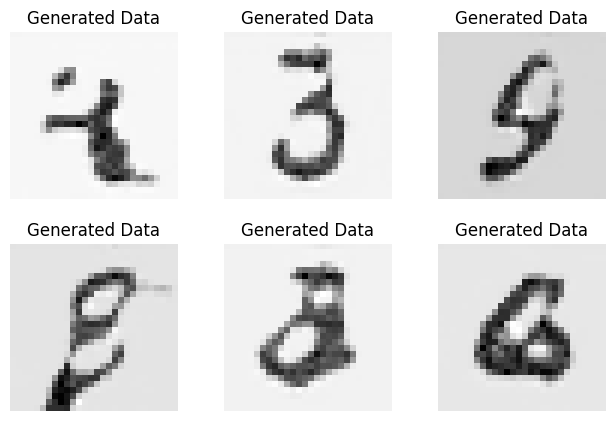


epoch 21


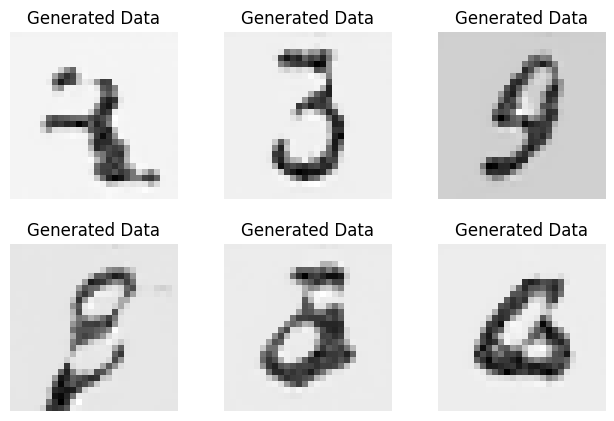


epoch 22


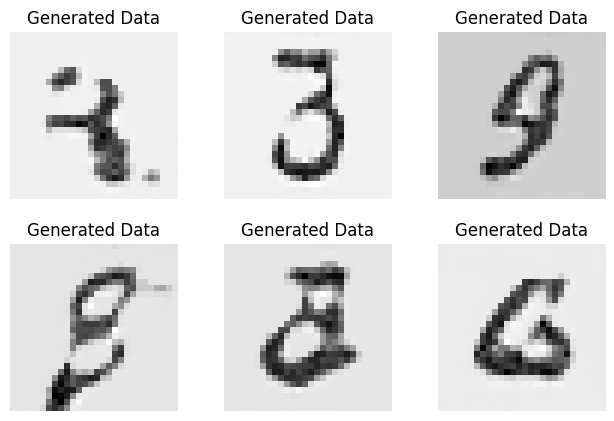


epoch 23


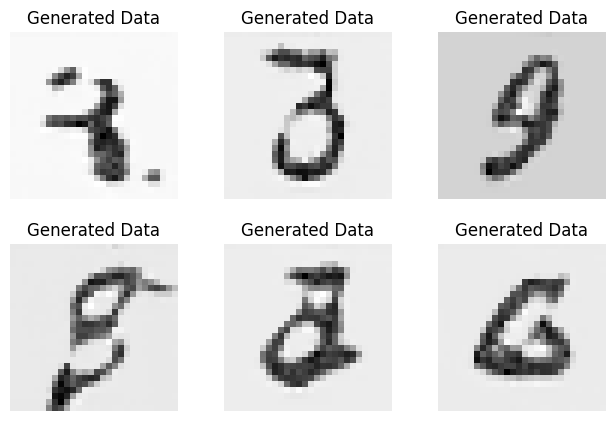


epoch 24


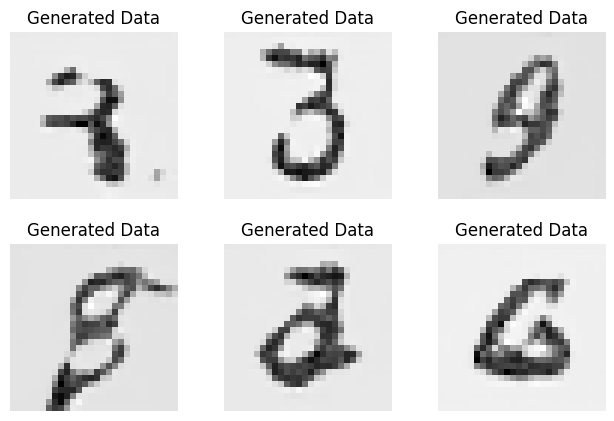


epoch 25


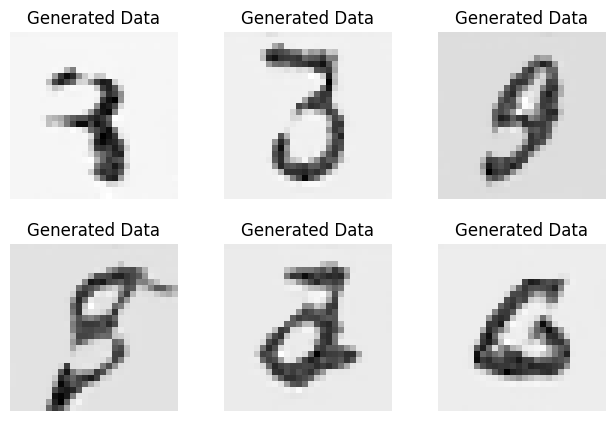


epoch 26


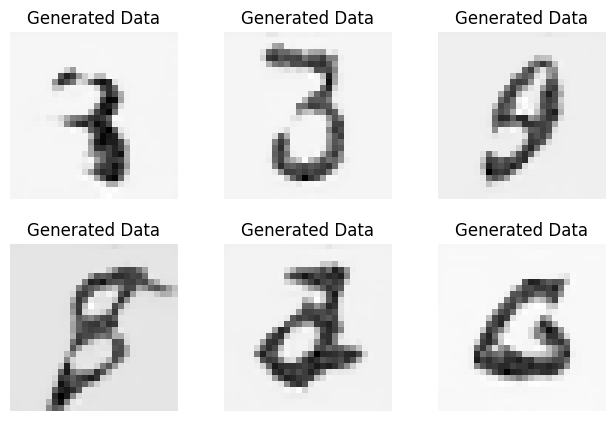


epoch 27


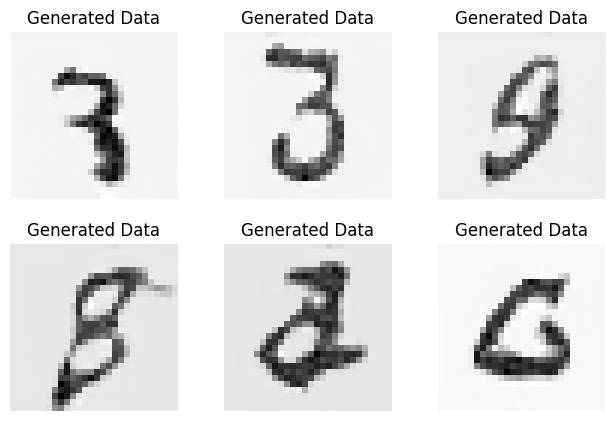


epoch 28


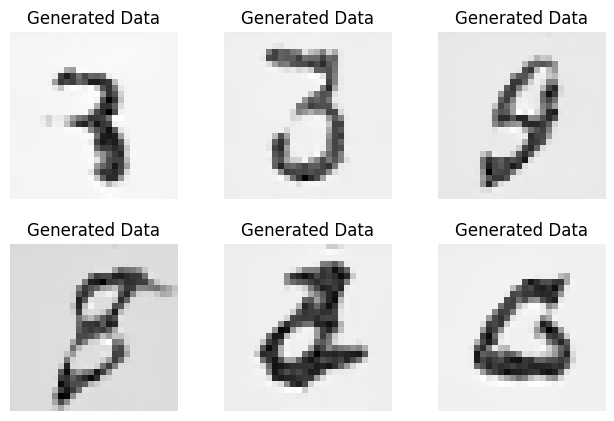


epoch 29


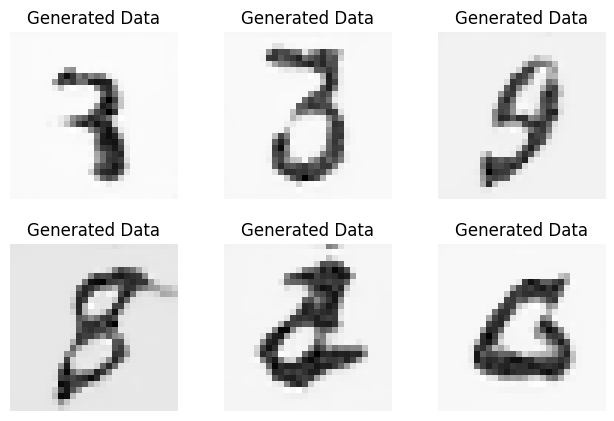

In [ ]:
trainer = pl.Trainer(max_epochs = 30 , gpus = AVAIL_GPUS)
trainer.fit(model , dm)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
---------

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'progress_bar', 'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


epoch 0


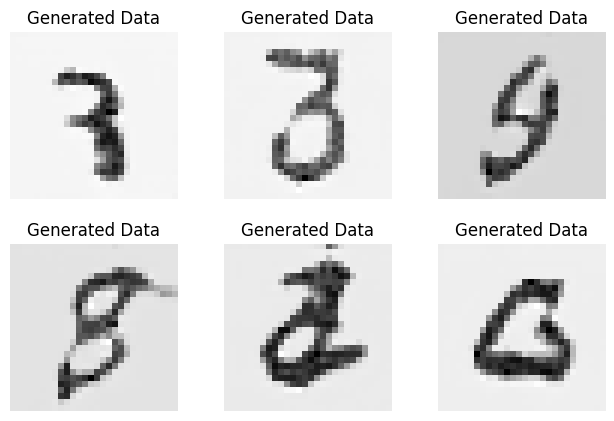


epoch 1


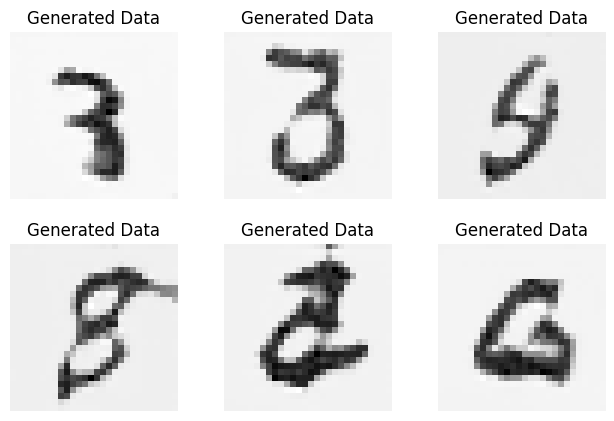


epoch 2


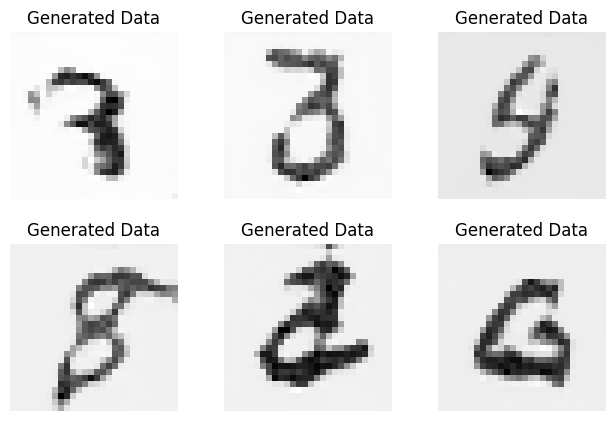


epoch 3


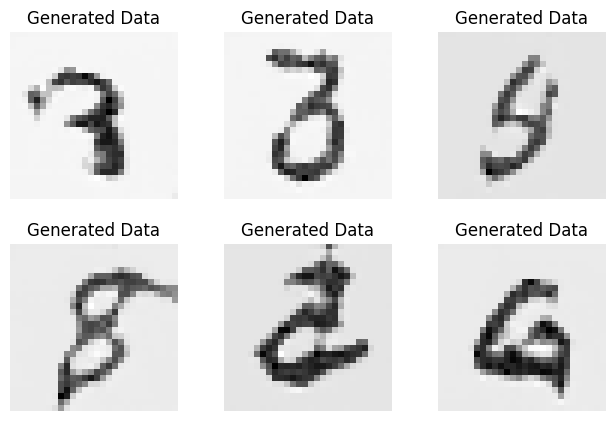


epoch 4


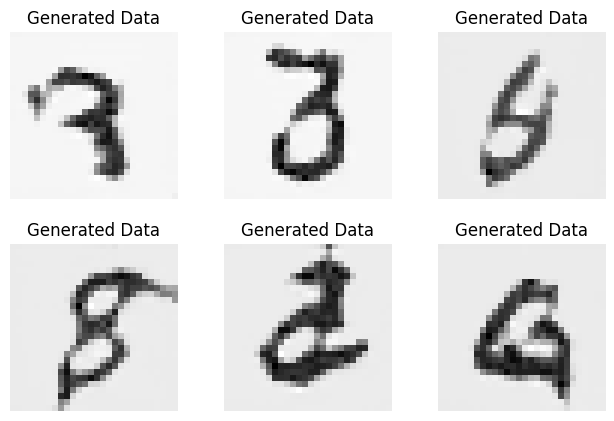


epoch 5


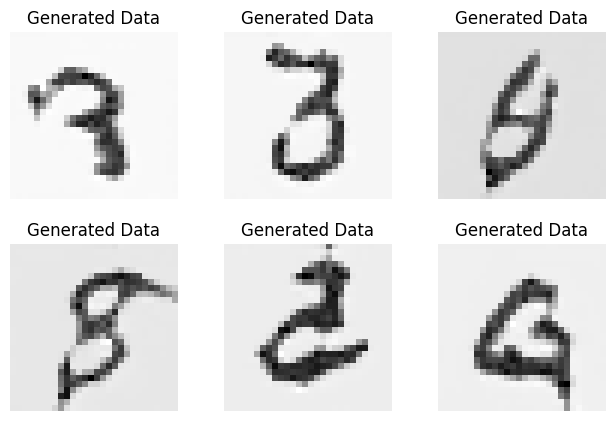


epoch 6


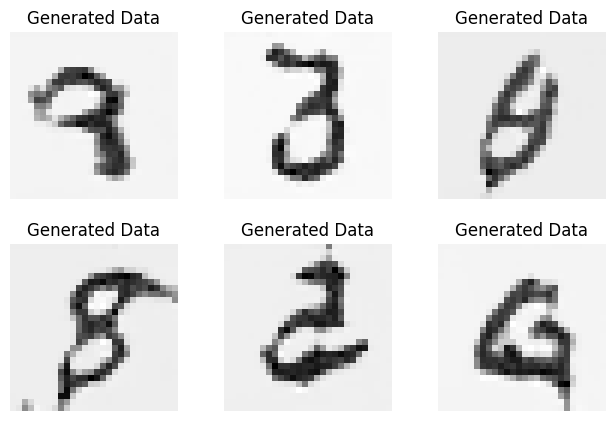


epoch 7


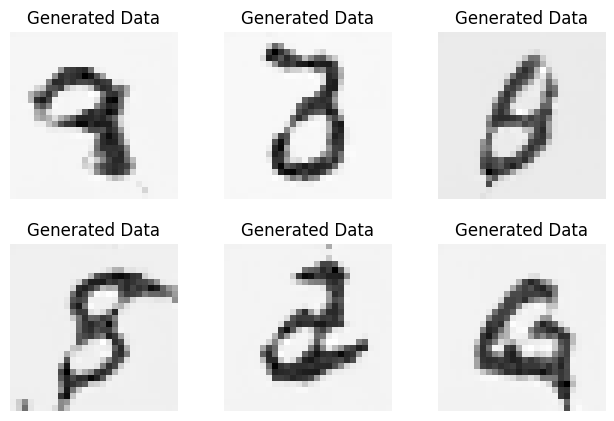


epoch 8


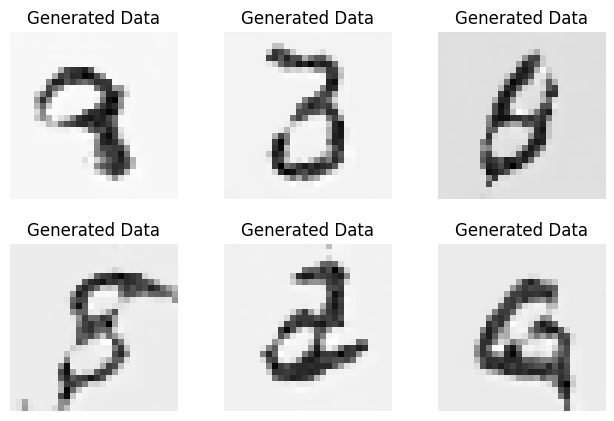


epoch 9


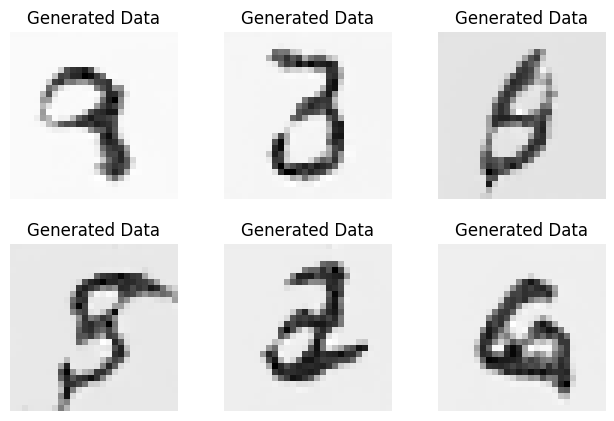


epoch 10


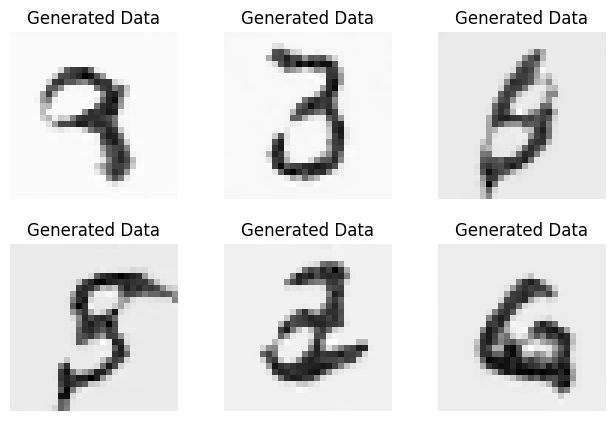


epoch 11


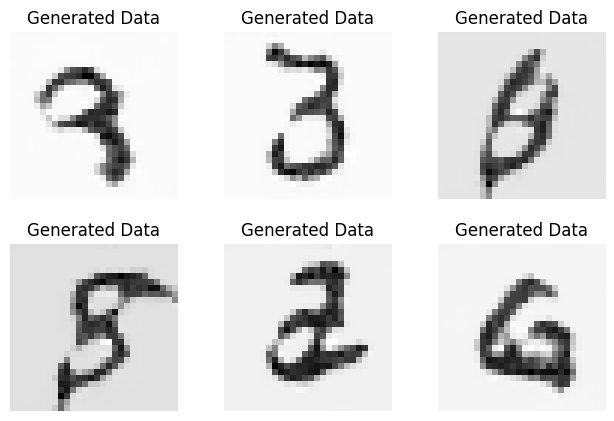


epoch 12


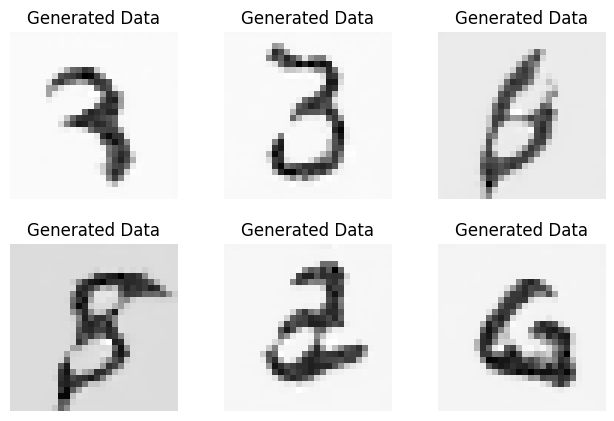


epoch 13


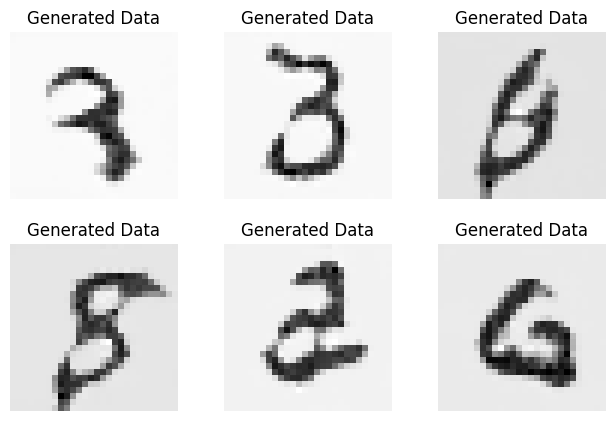


epoch 14


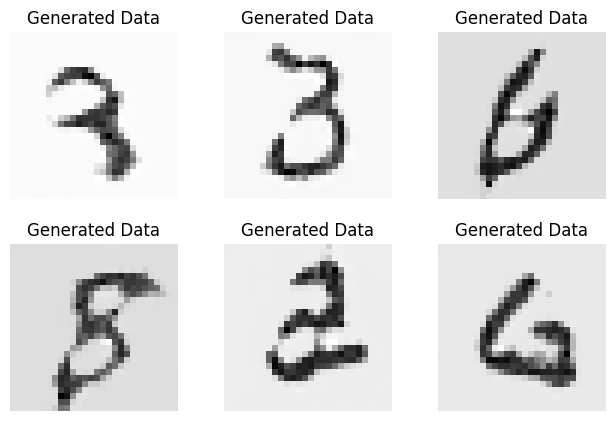


epoch 15


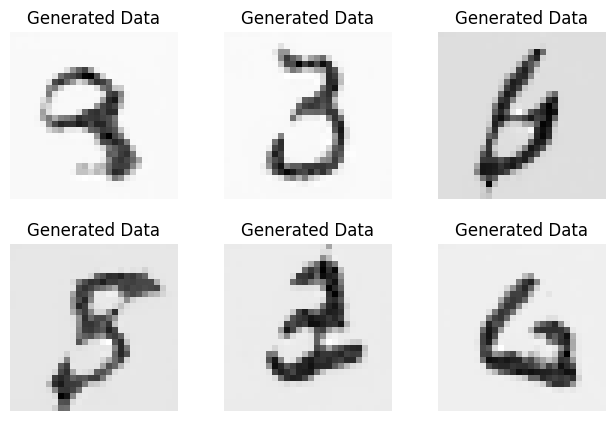


epoch 16


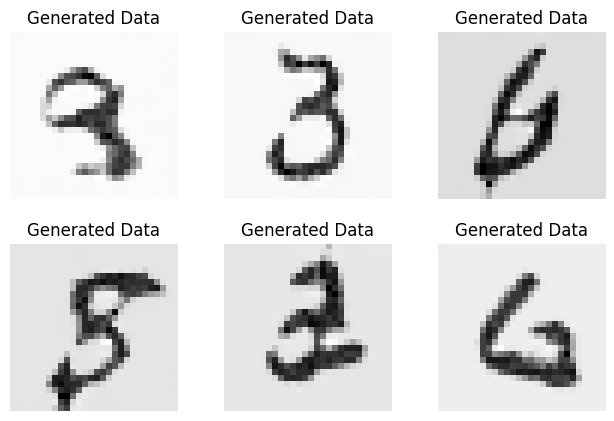


epoch 17


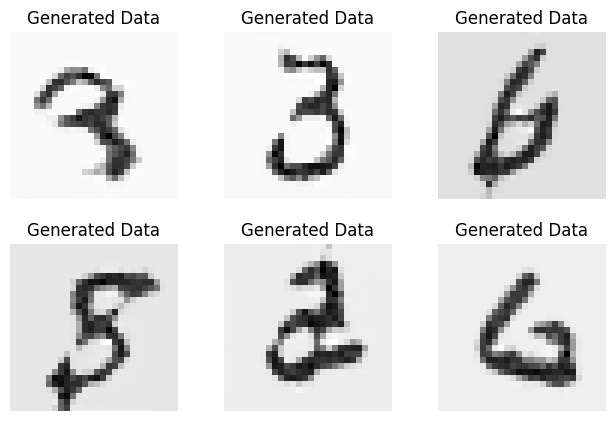


epoch 18


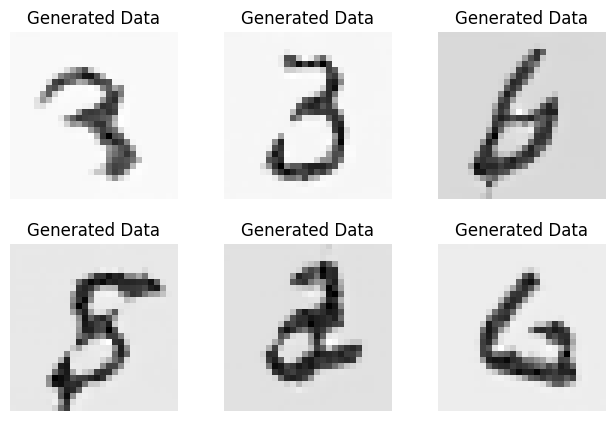


epoch 19


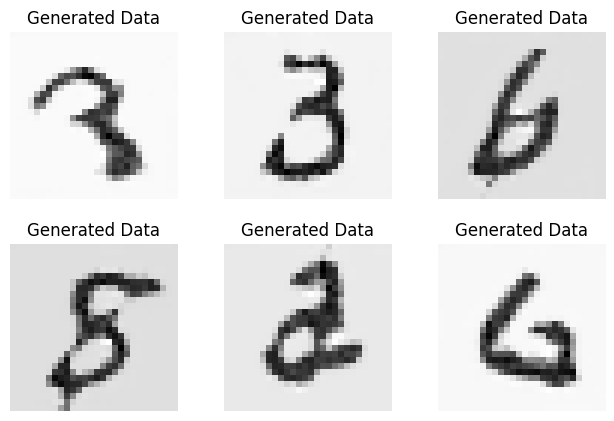


epoch 20


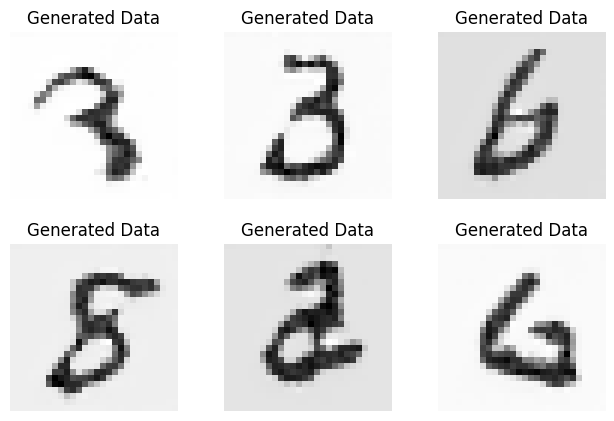


epoch 21


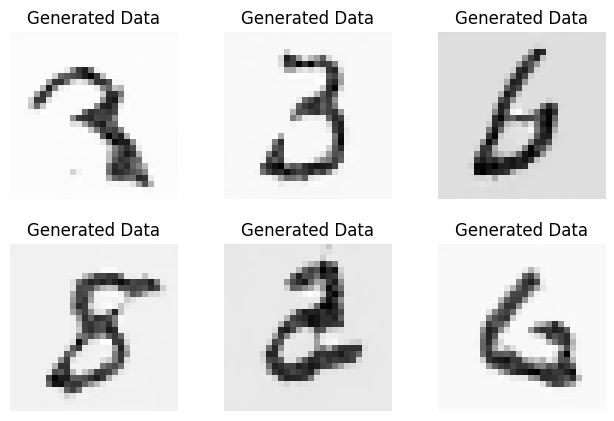


epoch 22


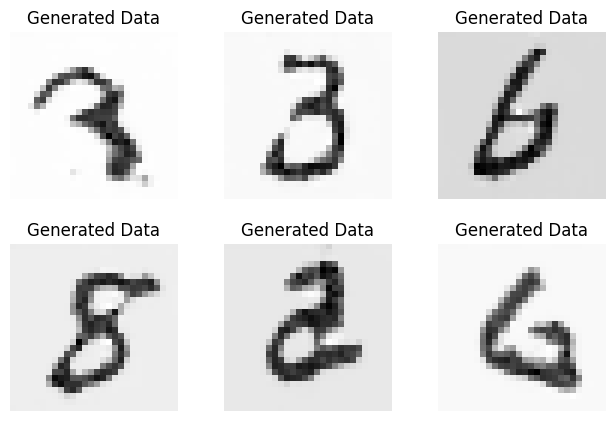


epoch 23


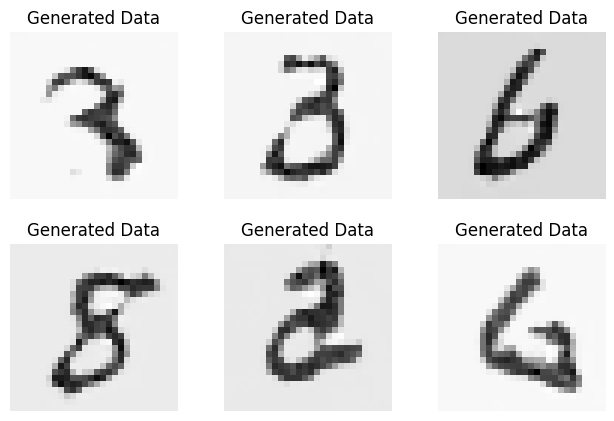


epoch 24


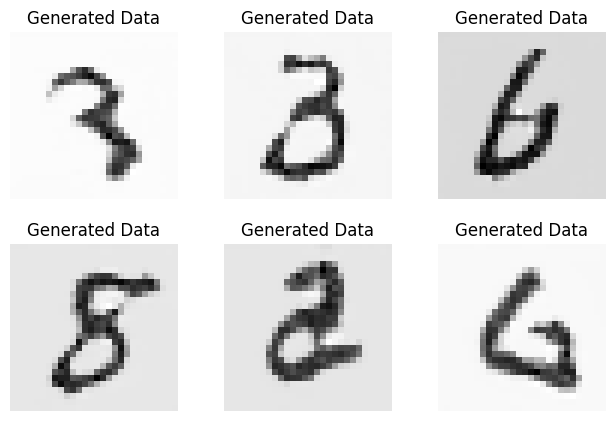


epoch 25


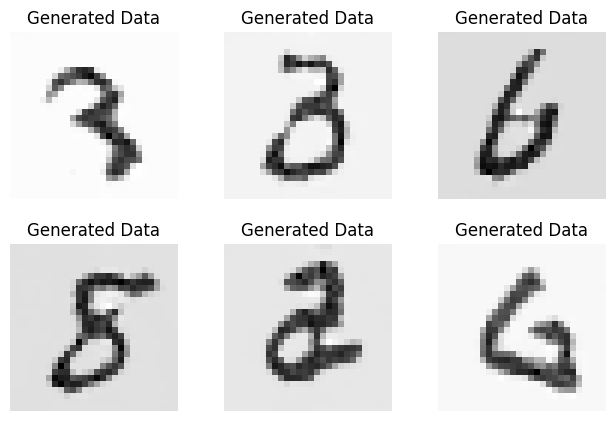


epoch 26


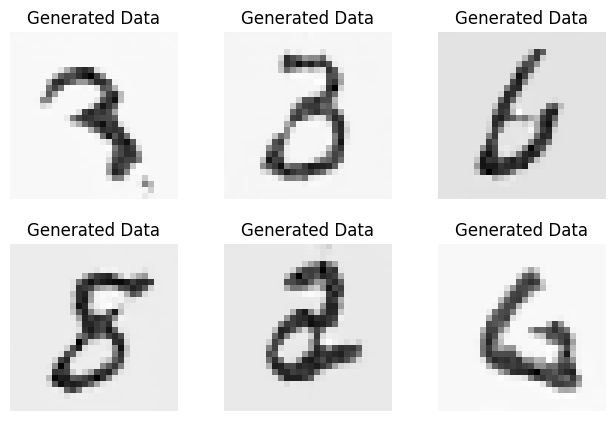


epoch 27


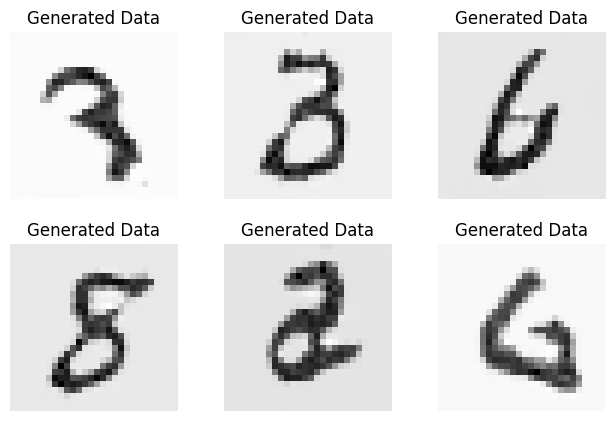


epoch 28


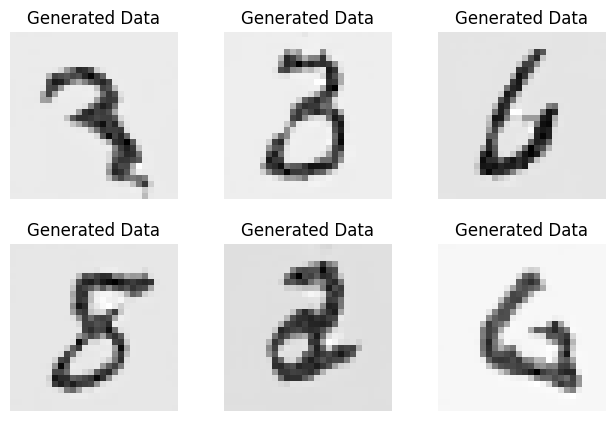


epoch 29


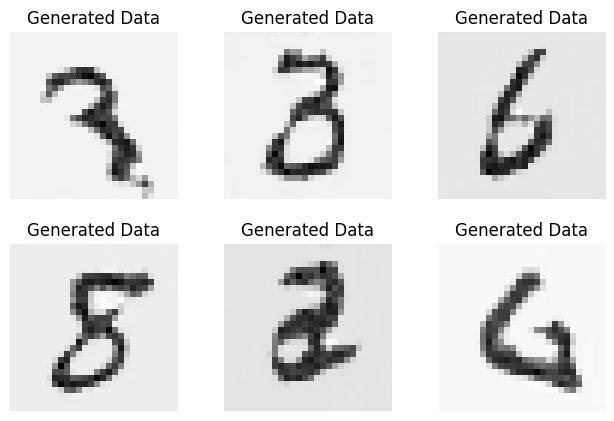


epoch 30


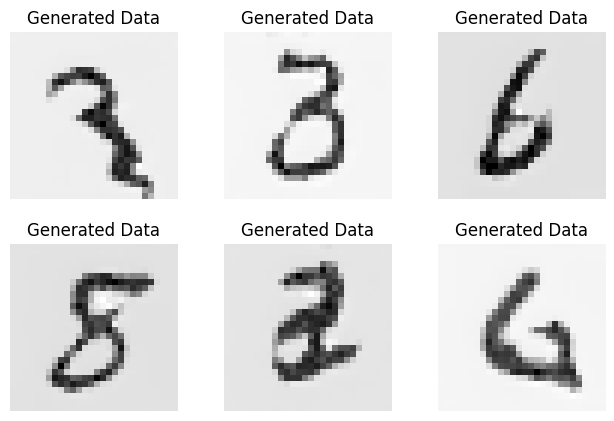


epoch 31


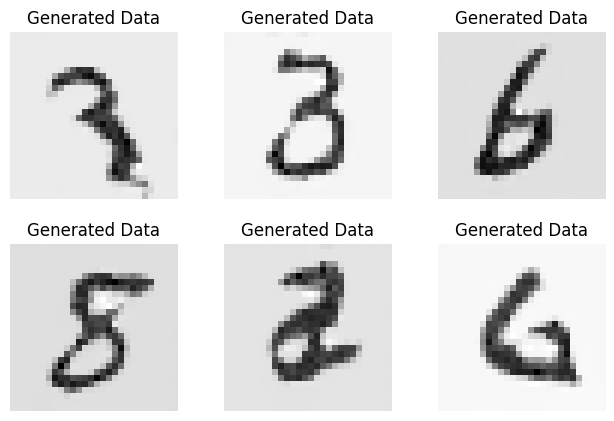


epoch 32


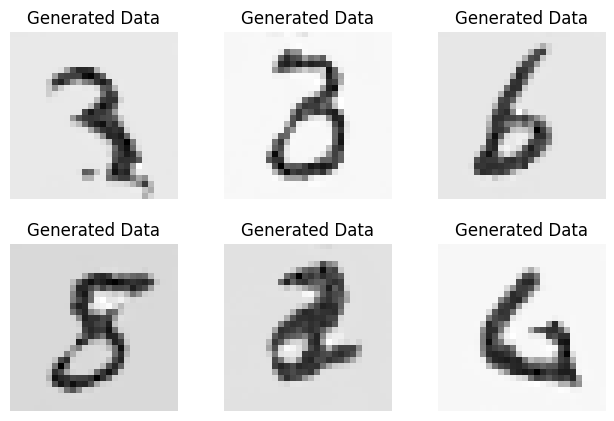


epoch 33


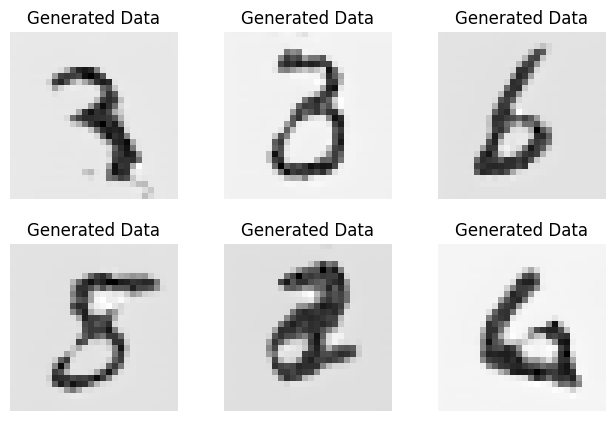


epoch 34


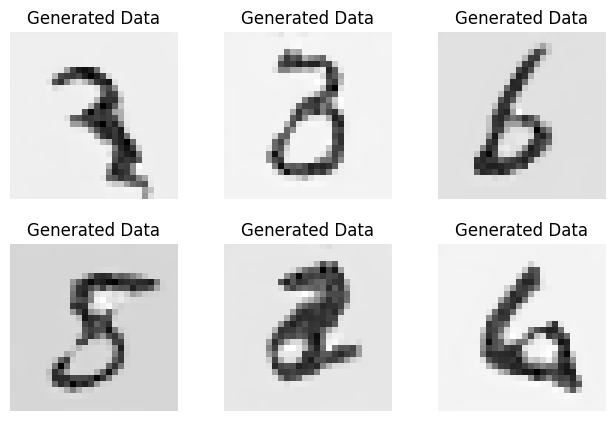


epoch 35


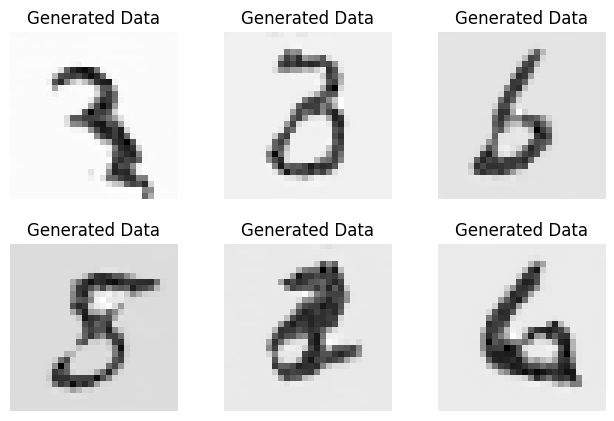


epoch 36


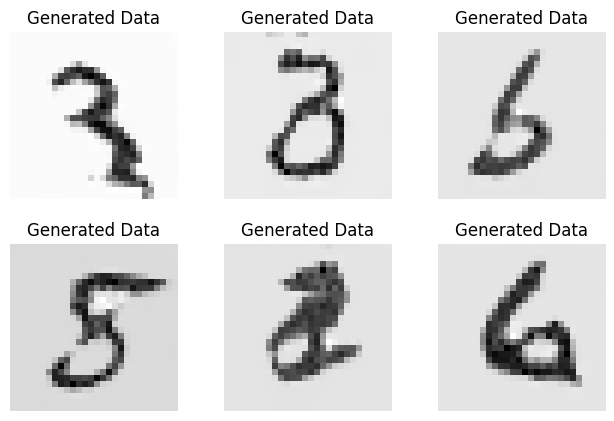


epoch 37


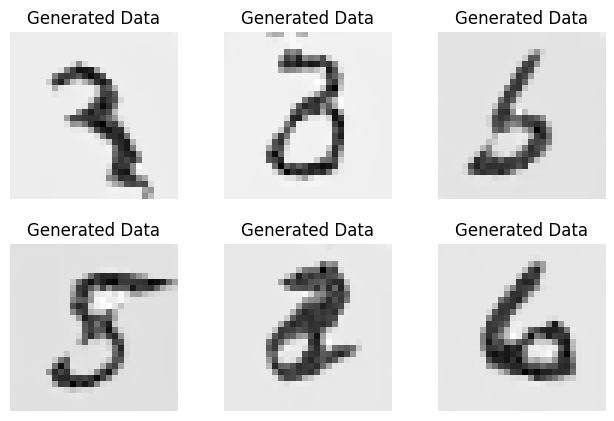


epoch 38


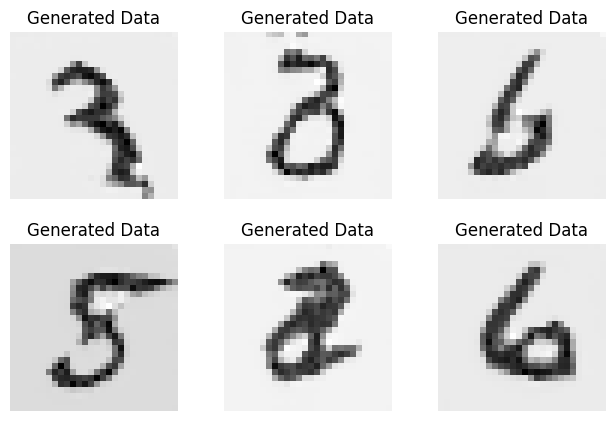


epoch 39


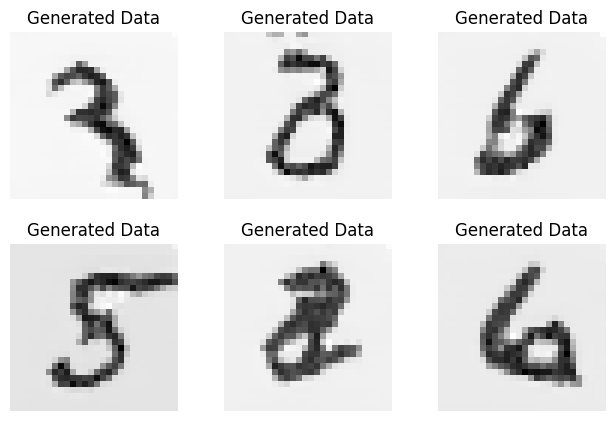


epoch 40


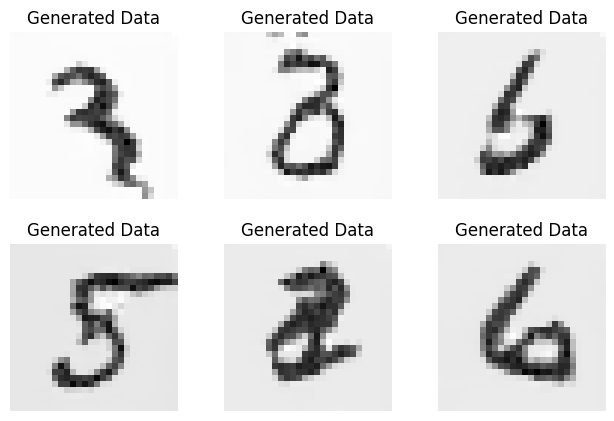


epoch 41


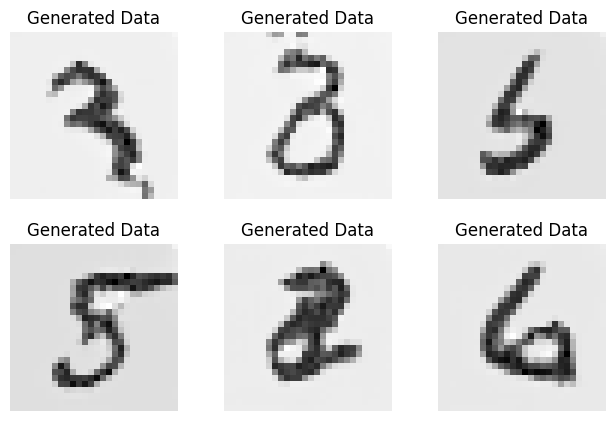


epoch 42


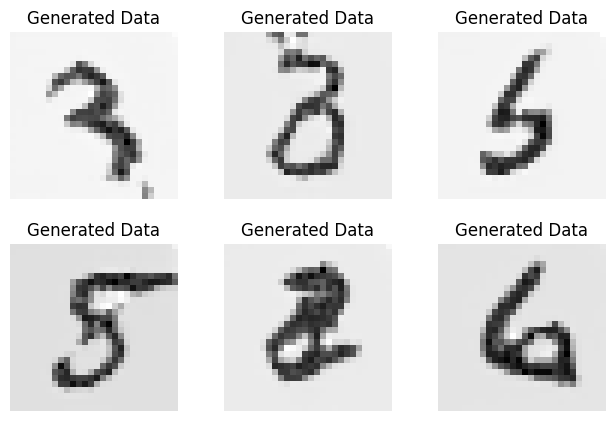


epoch 43


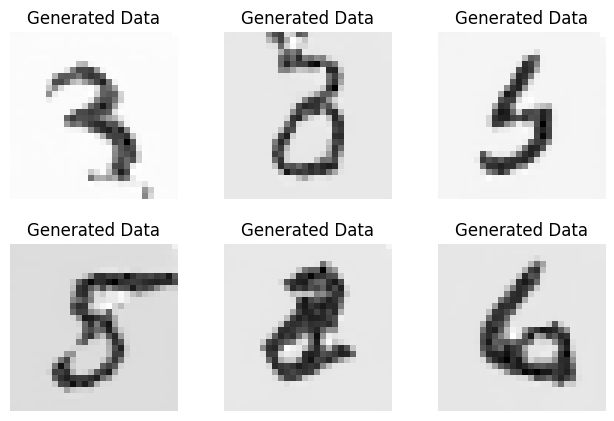


epoch 44


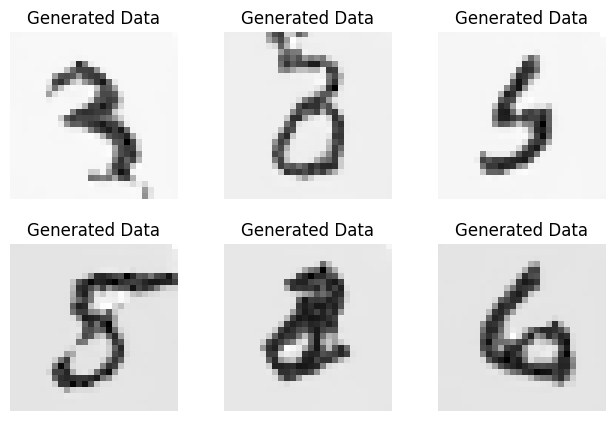


epoch 45


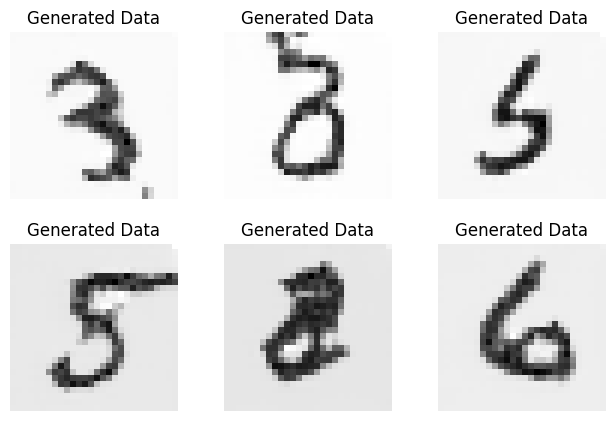


epoch 46


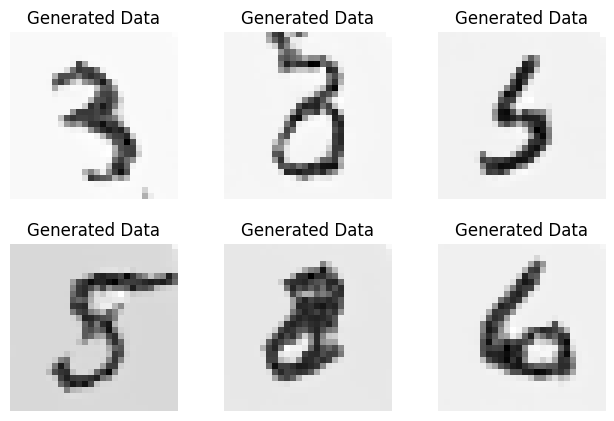


epoch 47


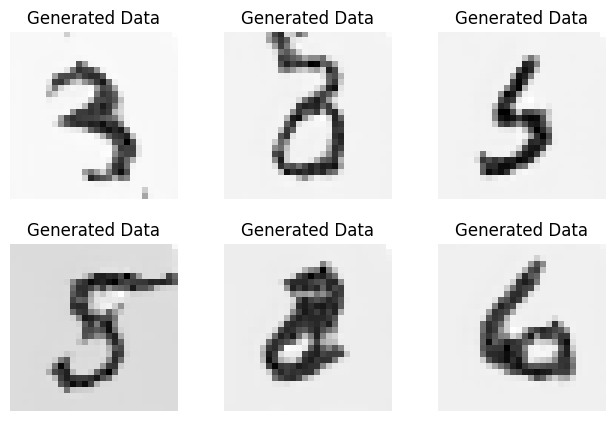


epoch 48


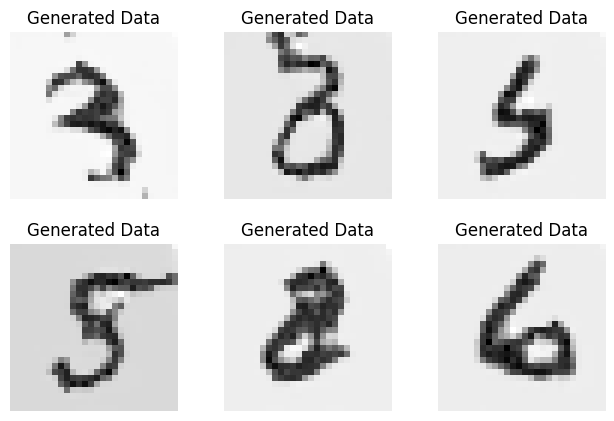


epoch 49


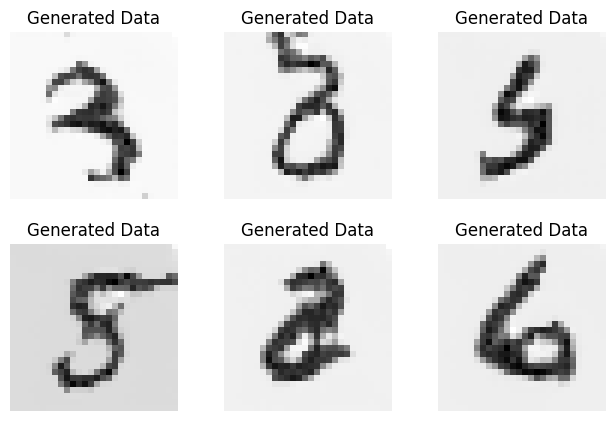

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [ ]:
trainer = pl.Trainer(max_epochs = 50 , gpus = AVAIL_GPUS)
trainer.fit(model , dm)